In [2]:
! pip install yfinance

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
import warnings
from tensorflow.keras.utils import get_file
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import SimpleRNN

In [5]:
def data_to_X_y(temp, window_size=5):
  data_as_np=temp.to_numpy()
  X = []
  y = []
  for i in range(len(data_as_np)-window_size):
    row = [[a] for a in data_as_np[i:i+5]]
    X.append(row)
    label = data_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [6]:
def train_test_val_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
  print('Train Set: ', X_train.shape, y_train.shape)
  print('Test Set: ', X_test.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [7]:
# Performance Metric
def metric(model, X_test, y_test):
  yhat=model.predict(X_test)
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]

In [8]:
score_dict={}

In [9]:
def magnitude_warp_time_series(data, column_name, scaling_factor):
    warped_data = data.copy()
    warped_data[column_name] = data[column_name] * scaling_factor
    return warped_data


# **Climate Data**

In [10]:
# Download and load the dataset
zip_path = get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
data = pd.read_csv(csv_path)

13568290/13568290 [==============================] - 0s 0us/step


In [11]:
data.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


In [12]:
data.index = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S')
warped_data = magnitude_warp_time_series(data, 'T (degC)', scaling_factor=0.5)
temp = warped_data['T (degC)']

In [13]:
WINDOW_SIZE=5
X, y=data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (294382, 5, 1) (294382,)
Test Set:  (126164, 5, 1) (126164,)


## **LSTM**

In [14]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
9200/9200 [==============================] - 124s 13ms/step - loss: 0.0595 - val_loss: 0.0116
Epoch 2/10
9200/9200 [==============================] - 99s 11ms/step - loss: 0.0127 - val_loss: 0.0109
Epoch 3/10
9200/9200 [==============================] - 106s 12ms/step - loss: 0.0122 - val_loss: 0.0120
Epoch 4/10
9200/9200 [==============================] - 93s 10ms/step - loss: 0.0120 - val_loss: 0.0135
Epoch 5/10
9200/9200 [==============================] - 96s 10ms/step - loss: 0.0119 - val_loss: 0.0126
Epoch 6/10
9200/9200 [==============================] - 108s 12ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 7/10
9200/9200 [==============================] - 99s 11ms/step - loss: 0.0116 - val_loss: 0.0109
Epoch 8/10
9200/9200 [==============================] - 95s 10ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 9/10
9200/9200 [==============================] - 93s 10ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 10/10
9200/9200 [==============================] - 97s 

In [15]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Climate']= LSTM_

3943/3943 [==============================] - 11s 3ms/step
RMSE 0.10275686647757597
MSE 0.010558973608290376
MAE 0.06459966363274475


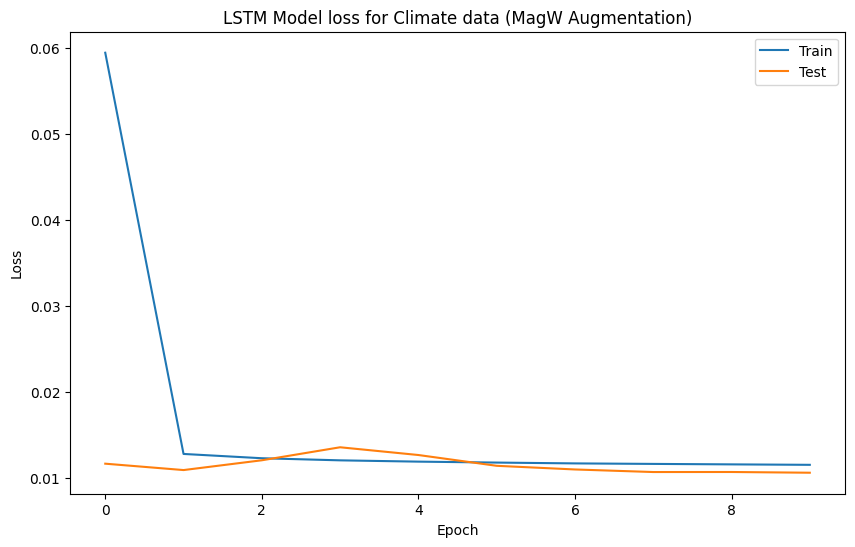

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for Climate data (MagW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

9200/9200 [==============================] - 23s 2ms/step


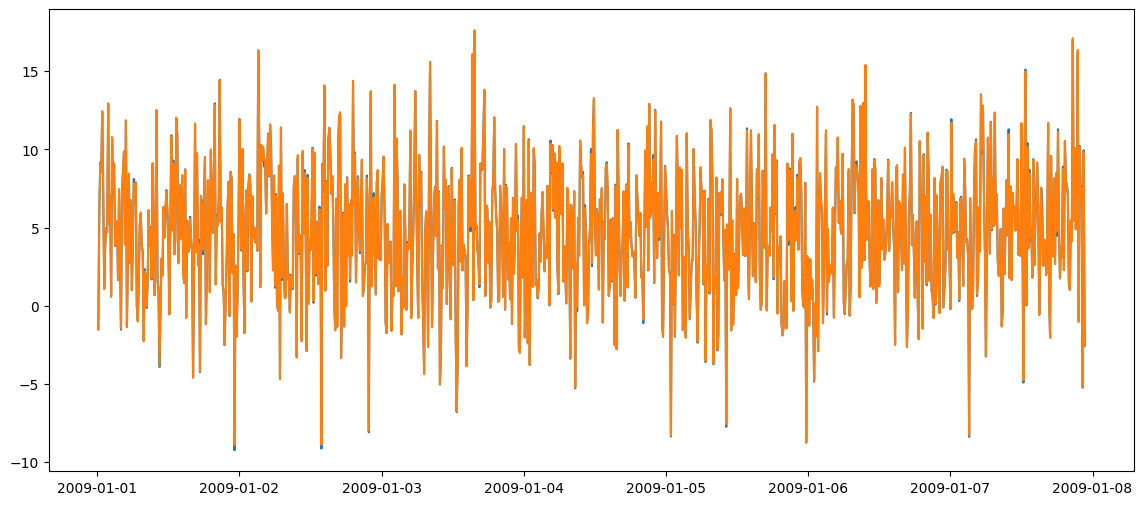

In [17]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=temp.head(294382).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

3943/3943 [==============================] - 10s 3ms/step


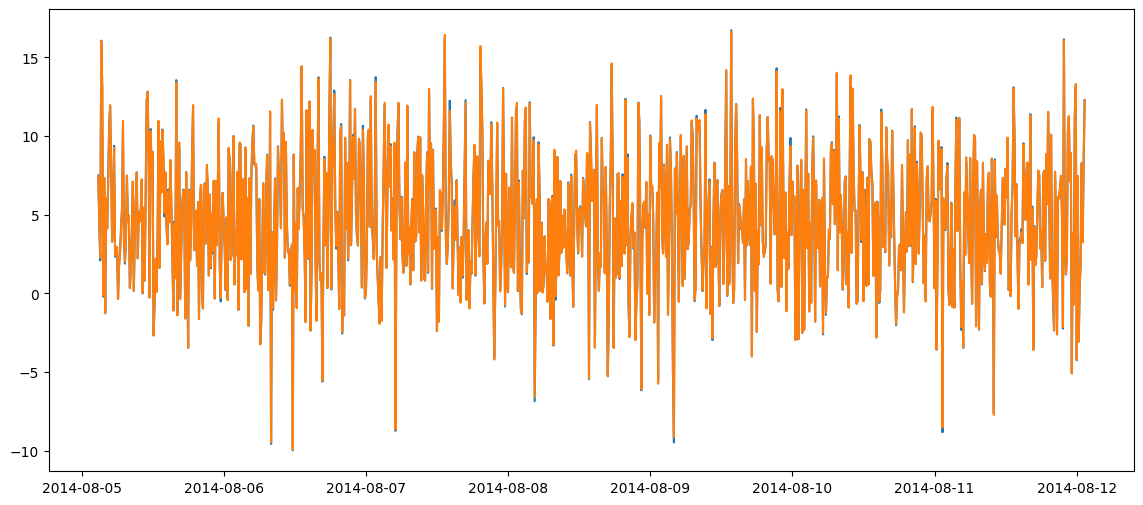

In [18]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=temp.tail(126164).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **ARIMA**

In [19]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(temp, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Climate']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

RMSE 5.7477140491712975
MSE 33.03621679104111
MAE 4.6090814550969705


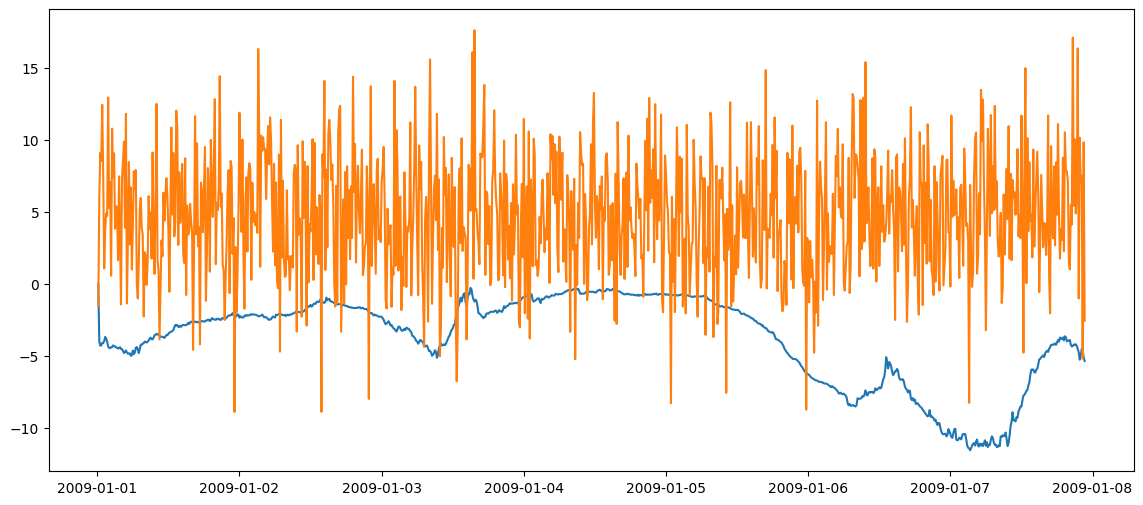

In [20]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

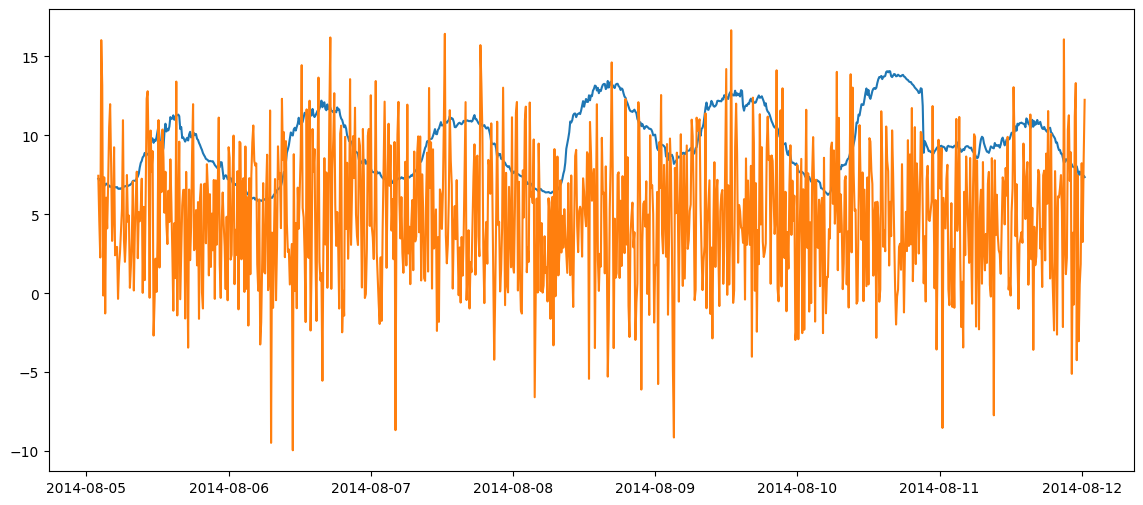

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [22]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Climate']= stacked_

RMSE 0.10263111691328573
MSE 0.010533146158868526
MAE 0.06455859604347909


# **Crypto Dataset (USDT)**

In [23]:
# Get bitcoin data
data=  yf.Ticker("USDT-USD").history(interval='1d', start='2000-01-01', end='2022-12-31').reset_index()
data.head(2)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-11-09 00:00:00+00:00,1.01087,1.01327,0.996515,1.00818,358188000,0.0,0.0
1,2017-11-10 00:00:00+00:00,1.00650,1.02423,0.995486,1.00601,756446016,0.0,0.0


In [24]:
data.index = pd.to_datetime(data['Date'], format='%d.%m.%Y %H:%M:%S')
warped_data = magnitude_warp_time_series(data, 'Close', scaling_factor=0.5)
usdt = warped_data['Close']

In [25]:
X, y=data_to_X_y(usdt, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (1311, 5, 1) (1311,)
Test Set:  (562, 5, 1) (562,)


## **LSTM**

In [26]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
41/41 [==============================] - 3s 27ms/step - loss: 0.2027 - val_loss: 0.1282
Epoch 2/10
41/41 [==============================] - 1s 16ms/step - loss: 0.0729 - val_loss: 0.0203
Epoch 3/10
41/41 [==============================] - 1s 16ms/step - loss: 0.0037 - val_loss: 1.3024e-04
Epoch 4/10
41/41 [==============================] - 1s 18ms/step - loss: 2.2902e-05 - val_loss: 5.1544e-06
Epoch 5/10
41/41 [==============================] - 1s 13ms/step - loss: 5.2874e-06 - val_loss: 4.0153e-06
Epoch 6/10
41/41 [==============================] - 0s 9ms/step - loss: 4.6972e-06 - val_loss: 4.0670e-06
Epoch 7/10
41/41 [==============================] - 0s 10ms/step - loss: 4.7003e-06 - val_loss: 4.0862e-06
Epoch 8/10
41/41 [==============================] - 0s 10ms/step - loss: 4.7043e-06 - val_loss: 4.0945e-06
Epoch 9/10
41/41 [==============================] - 0s 10ms/step - loss: 4.7063e-06 - val_loss: 4.1008e-06
Epoch 10/10
41/41 [==============================] - 0s 9m

In [27]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_USDT']= LSTM_

18/18 [==============================] - 0s 2ms/step
RMSE 0.002026056846922253
MSE 4.1049063469605415e-06
MAE 0.0011701840522874718


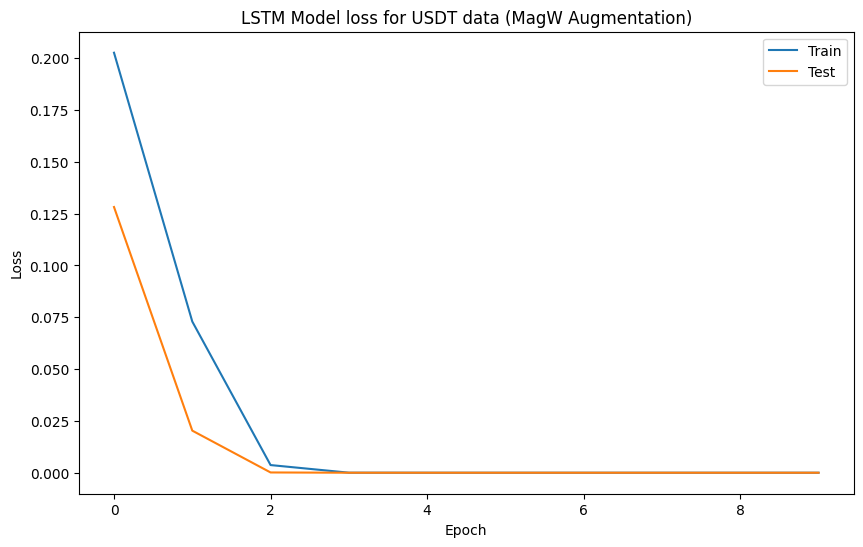

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for USDT data (MagW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

41/41 [==============================] - 0s 2ms/step


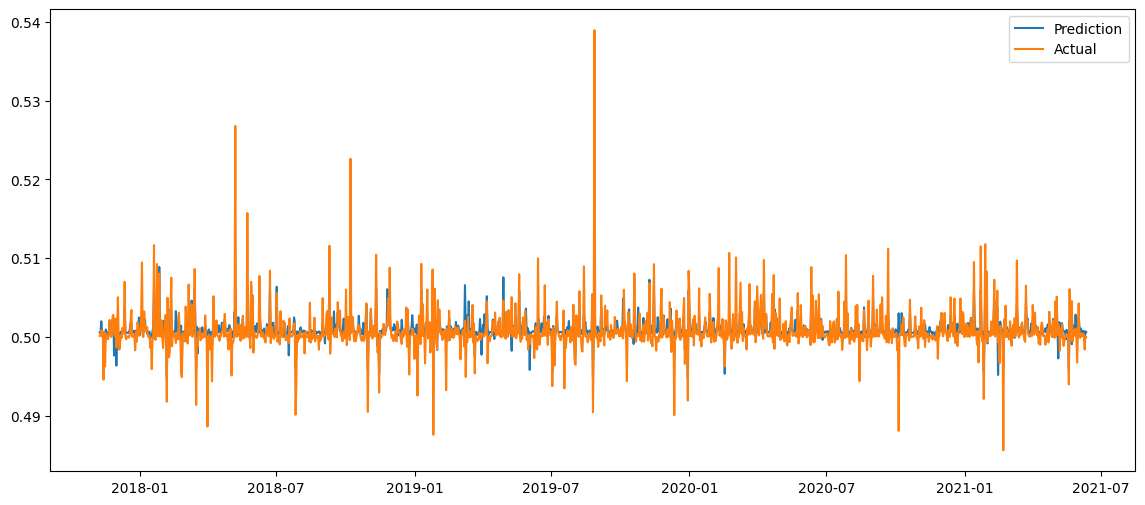

In [29]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=usdt.head(1311).index
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'], label='Prediction')
plt.plot(train_results['Actuals'], label='Actual')
plt.legend()

18/18 [==============================] - 0s 2ms/step


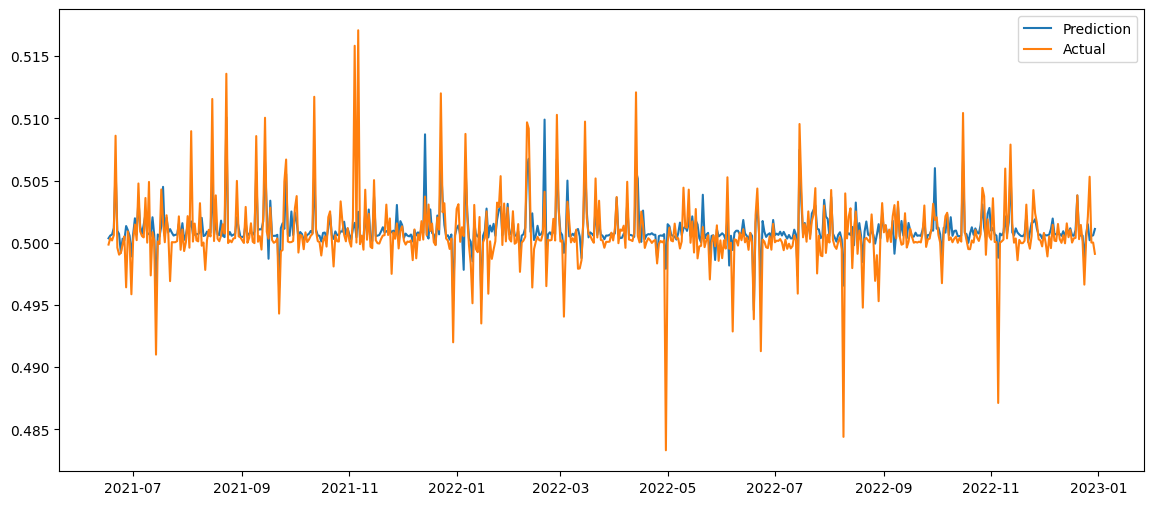

In [30]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=usdt.tail(562).index
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'], label='Prediction')
plt.plot(test_results['Actuals'], label='Actual')
plt.legend()

## **ARIMA**

In [31]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(usdt, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_USDT']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE 0.0029520214125054096
MSE 8.714430419890434e-06
MAE 0.0015605957405139962


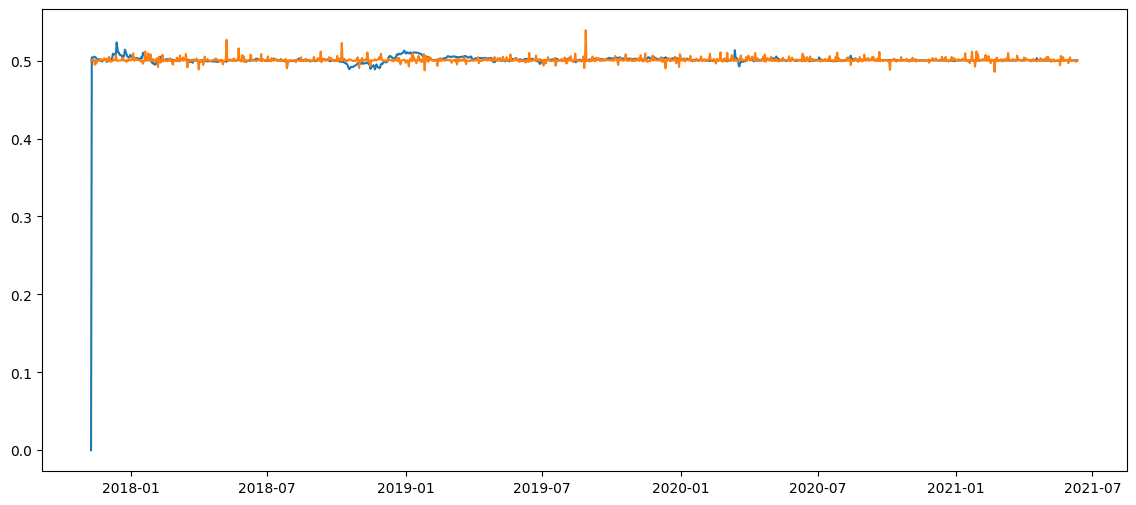

In [32]:
plt.figure(figsize=(14, 6))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

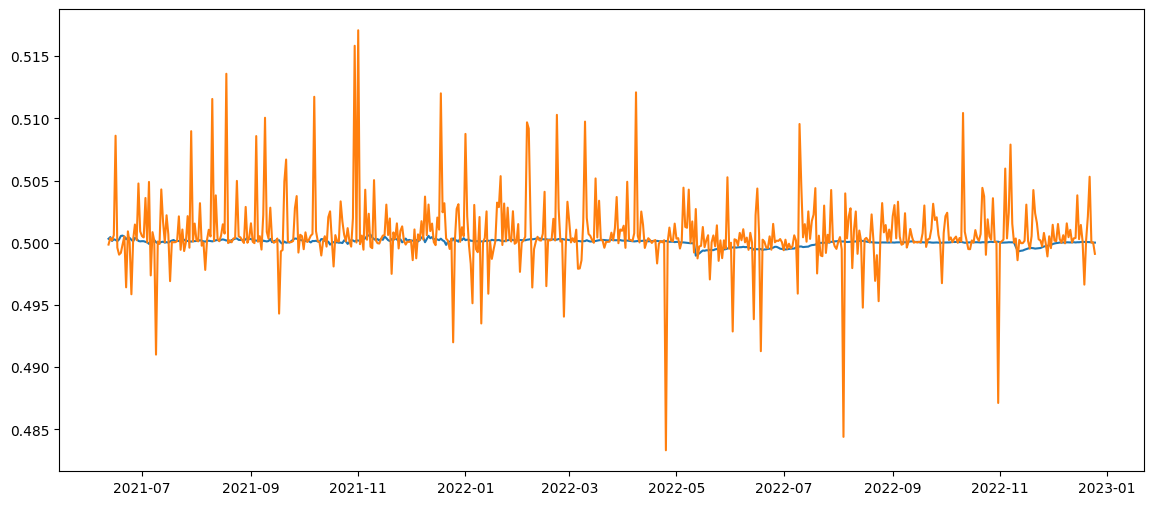

In [33]:
plt.figure(figsize=(14, 6))
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

## **Stacking**

In [34]:
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_USDT']= stacked_

RMSE 0.0019135704498173547
MSE 3.661751866414193e-06
MAE 0.000982359629434271


# **Plant Sensor Data**

In [35]:
df=pd.read_csv('/content/drive/MyDrive/measures.csv')
df.head()

,mp,temperature,humidity,moisture,light,date,time
0,n1,24.7,57.9,1995,0.0,2022-09-15,00:00:04
1,n1,24.7,58.0,1991,0.0,2022-09-15,00:00:09
2,n1,24.7,58.2,1994,0.0,2022-09-15,00:00:14
3,n1,24.6,58.0,1993,0.0,2022-09-15,00:00:19
4,n1,24.6,58.0,1986,0.0,2022-09-15,00:00:25


In [36]:
df.date=pd.to_datetime(df['date'] + ' ' + df['time'])
df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')

In [37]:
warped_data = magnitude_warp_time_series(df, 'humidity', scaling_factor=0.5)
humidity = warped_data['humidity']

In [38]:
WINDOW_SIZE=5
X, y=data_to_X_y(humidity, WINDOW_SIZE)
X.shape, y.shape
X_train, X_test, y_train, y_test=train_test_val_split(X, y)

Train Set:  (163782, 5, 1) (163782,)
Test Set:  (70193, 5, 1) (70193,)


## **LSTM**

In [39]:
model = Sequential()
model.add(LSTM(16, return_sequences=False, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)

Epoch 1/10
5119/5119 [==============================] - 57s 11ms/step - loss: 14.0100 - val_loss: 0.0151
Epoch 2/10
5119/5119 [==============================] - 52s 10ms/step - loss: 0.0130 - val_loss: 0.0102
Epoch 3/10
5119/5119 [==============================] - 51s 10ms/step - loss: 0.0117 - val_loss: 0.0097
Epoch 4/10
5119/5119 [==============================] - 52s 10ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 5/10
5119/5119 [==============================] - 59s 11ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 6/10
5119/5119 [==============================] - 51s 10ms/step - loss: 0.0101 - val_loss: 0.0085
Epoch 7/10
5119/5119 [==============================] - 53s 10ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 8/10
5119/5119 [==============================] - 52s 10ms/step - loss: 0.0099 - val_loss: 0.0083
Epoch 9/10
5119/5119 [==============================] - 53s 10ms/step - loss: 0.0098 - val_loss: 0.0083
Epoch 10/10
5119/5119 [==============================] - 57s 11

In [40]:
LSTM_=metric(model, X_test, y_test)
score_dict['LSTM_Humidty']= LSTM_

2194/2194 [==============================] - 5s 2ms/step
RMSE 0.09092489123353673
MSE 0.008267335845830483
MAE 0.060292633901120565


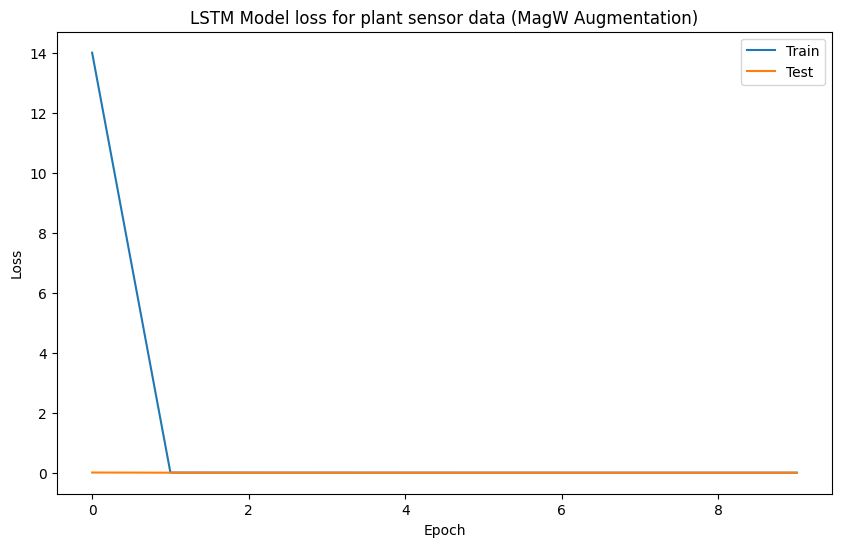

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model loss for plant sensor data (MagW Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

5119/5119 [==============================] - 14s 3ms/step


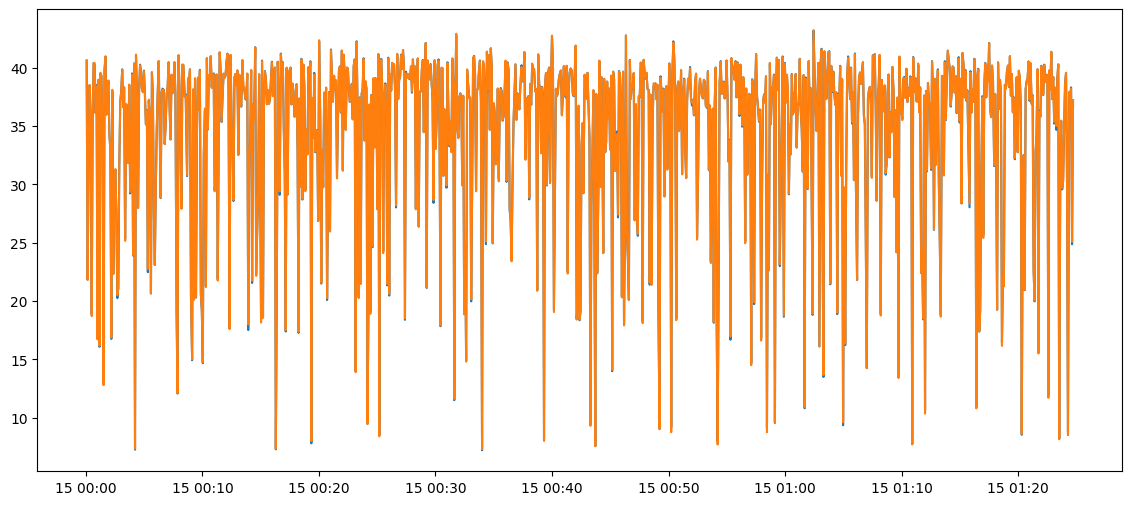

In [42]:
train_predictions_lstm=model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions_lstm, 'Actuals': y_train})
train_results.index=humidity.head(163782).index
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

2194/2194 [==============================] - 5s 2ms/step


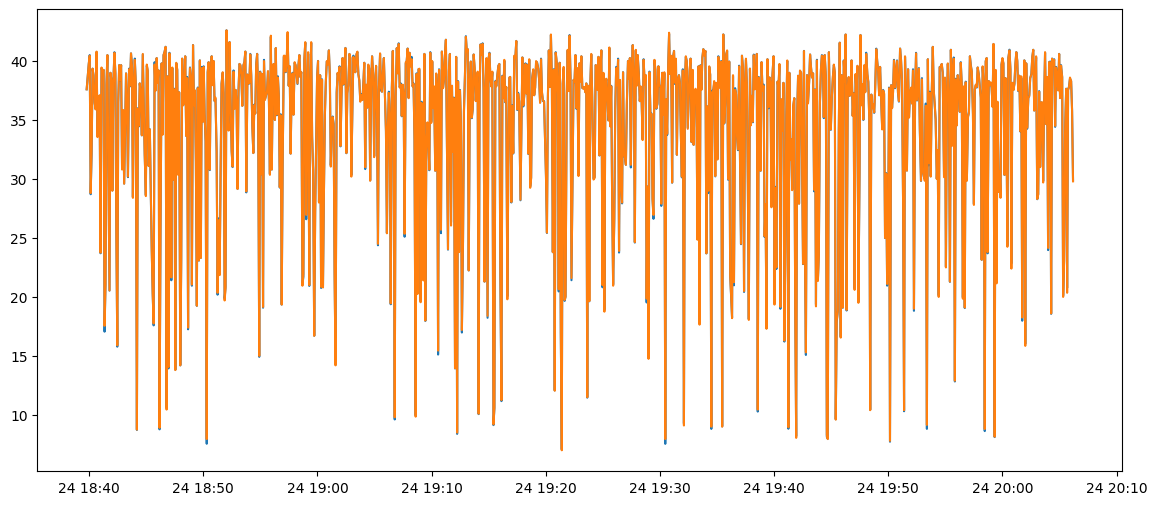

In [43]:
test_predictions_lstm=model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions_lstm, 'Actuals': y_test})
test_results.index=humidity.tail(70193).index
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **ARIMA**

In [44]:
# Performance Metric
def metric_(y_test, test_predictions):
  yhat=test_predictions
  y=y_test
  from sklearn.metrics import mean_squared_error
  RMSE=mean_squared_error(y, yhat, squared=False )
  MSE= mean_squared_error(y, yhat )
  MAE= mean_absolute_error(y, yhat)
  print('RMSE', RMSE )
  print('MSE', MSE)
  print('MAE', MAE )
  return [RMSE, MSE, MAE]


# Fit an ARIMA model
import statsmodels.api as sm
p, d, q = 1, 1, 1  # Example values, you may need to adjust these
arima_model = sm.tsa.ARIMA(humidity, order=(p, d, q))
# Assuming you have already fitted the ARIMA model
arima_results = arima_model.fit()  # Fit the ARIMA model, you may have different parameters

# Get predictions on the training data
train_predictions_arima = arima_results.predict(start=0, end=len(X_train)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
train_results = pd.DataFrame({'Train Predictions': train_predictions_arima, 'Actuals': y_train})

# Get predictions on the training data
test_predictions_arima = arima_results.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, typ='levels')  # Adjust start and end accordingly

# Create a DataFrame to store the results
test_results = pd.DataFrame({'Test Predictions': test_predictions_arima , 'Actuals': y_test})

arima=metric_(y_test, test_predictions_arima  )
score_dict['ARIMA_Humidity']= arima

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RMSE 9.242256396336295
MSE 85.41930329561916
MAE 6.097473107432667


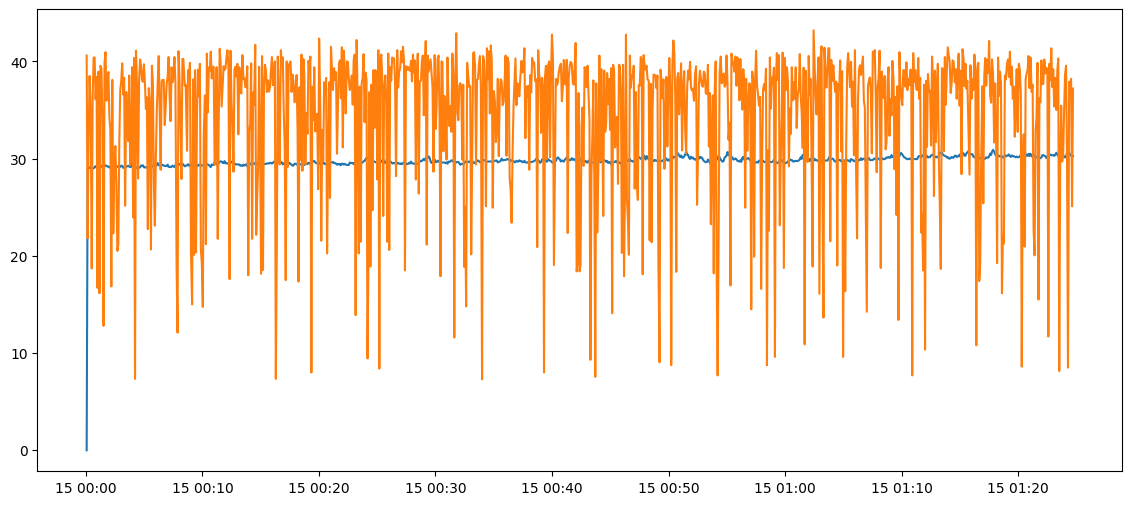

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(train_results.head(1000)['Train Predictions'])
plt.plot(train_results.head(1000)['Actuals'])

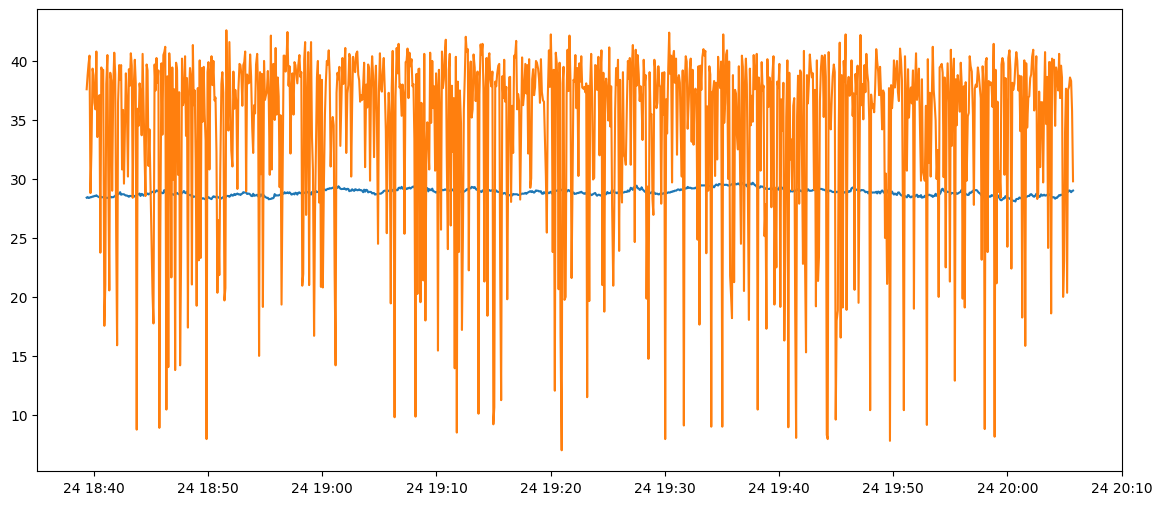

In [46]:
plt.figure(figsize=(14, 6))
plt.plot(test_results.head(1000)['Test Predictions'])
plt.plot(test_results.head(1000)['Actuals'])

## **Stacking**

In [47]:
from sklearn.linear_model import LinearRegression
Lr=LinearRegression ()
df_train=pd.DataFrame({'LSTM': train_predictions_lstm, 'RNN': train_predictions_arima})
Lr.fit(df_train, y_train)
df_test=pd.DataFrame({'LSTM': test_predictions_lstm, 'RNN': test_predictions_arima})
stacked_=metric(Lr, df_test, y_test)
score_dict['Stacked_Humidity']= stacked_

RMSE 0.09042338317719002
MSE 0.008176388225208933
MAE 0.05973290999608177


# **Results**

In [48]:
Result=pd.DataFrame(score_dict).T
Result.columns=['RMSE', 'MSE', 'MAE']
Result[ 'Dat']=Result.index.str.split('_')
Result['Data']=Result[ 'Dat'].str[1]
Result['Model']=Result['Dat'].str[0]
Result.drop('Dat', axis=1, inplace=True)
Result=Result.set_index('Data')
Result=Result[['Model', 'RMSE', 'MSE', 'MAE']]
Result.to_csv('/content/drive/MyDrive/New TS DA/MagW_Augmentation.csv')